
Cuando se haya utilizado código generado por IA se hará saber con un comentario.

# Introducción y limpieza de la base de datos

En este proyecto se intenta utilizar una base de datos del censo de población y vivienda del 2020 por el INEGI para entrenar un modelo de regresión múltiple que pueda predecir la población local en base a las condiciones de vivienda. 

La base de datos original incluye más de 200 variables relacionadas con datos demográficos como sexo, edad, origen étnico, discapacidades o problemas para realizar actividades, etc. En aras de mejorar la interpretabilidad y reducir redundancias se decidió delimitar los datos a solamente las variables que hablan de condiciones de vivienda, por lo que se redujeron a aproximadamente 60 variables. De estas variables también se eliminaron variables que decían cosas muy similares o estaban correlacionadas de una manera que podría interferir con un análisis más interesante. 

No se va a comentar sobre todas las variables de la base proyecto, pero el lector puede ver qué información se incluye en cada una de ellas en el [diccionario de datos](https://github.com/Ethan-R-R/Modelo-Poblacion-por-condiciones-de-vivienda/blob/cc95bb65125c9c76c13b9de4af307c1aca0d4eed/diccionario_datos_iter_19CSV20.csv).

Para iniciar se va a importar la base de datos y se van a eliminar algunas variables que no son de mucho interés para el análisis numérico como el nombre de entidad, municipio (número), nombre de municipio, etc. 
Se va a dejar el nombre de la localidad, no para el análisis numérico sino porque más adelante van a servir para comprobar si los datos atípicos de población realmente son errores o si solamente son localidades de tamaño inusual, pero real. 

Al imprimir la forma del dataframe se puede observar que la base de datos cuenta con 4821 observaciones y 55 variables.

Sin embargo, la base de datos tiene muchos huecos. Por lo que es conveniente considerar si se deben de imputar datos o eliminar variables u observaciones. Para esto se añadió una columna temporal al dataframe en la que se contenga el conteo de espacios vacíos por fila. Después se eliminaron todas las observaciones con menos de la mitad de los datos, pues se consideró que con tantos huecos la información impputar podría causar más error que ayudar. 

Se utilizó una línea de código muy similar para eliminar todas las observaciones con al menos un hueco, y resulta que el tamaño del dataframe sigue igual; lo que significa que ya no hay huecos, no es necesario imputar datos.

El dataframe ahora cuenta con 1990 observaciones.

Quizá habrá notado la línea

df = df.drop(df[df["LATITUD"].isnull()].index)

Se incluyó porque la base de datos tiene los datos de cada localidad (que es lo que interesa para el proyecto); pero internamente también se segrega por municipio y cada que se termina con todas las localidades de un municipio, se hace un recuento del total por municipio. Esta información se consideró redundante, porque es una suma de datos que ya se tomaron en cuenta. Estas "observaciones" tienen la particularidad de no tener coordenadas (tienen un hueco en esa columna), pues no se habla de una localidad particular. Justamente se aprovecha de esto para borrar esos datos redundantes.


In [590]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

df = pd.read_csv("conjunto_de_datos_iter_19CSV20.csv")

#https://sparkbyexamples.com/pandas/pandas-delete-rows-based-on-column-value/#:~:text=To%20delete%20rows%20based%20on%20specific%20column%20values%20in%20a,method%20to%20remove%20those%20rows.
df = df.drop(df[df["LATITUD"].isnull()].index)

#variables cualitativas o redundantes se dejaron en la base de datos por si se quiere revisar individualmente algo de las caracteristicas de la zona
df = df.drop(columns = ['ENTIDAD','NOM_ENT','MUN','LOC','NOM_MUN','LONGITUD','LATITUD','ALTITUD'])
#Trabajaremos solo con las viviendas particulares. 
df = df.drop(columns = ['VIVTOT','TVIVHAB','TVIVPAR','OCUPVIVPAR','TVIVPARHAB'])

print("Tamaño original ", df.shape)
#la siguiente linea se genero con ayuda de chatgpt
#añade una columna que incluye la cantidad de huecos que tiene cada fila
df["DatosVacios"] = df.isnull().sum(axis=1)
print(df.DatosVacios)



df.drop(df[df["DatosVacios"]>=(30)].index, inplace=True)
print("Observaciones eliminando las que tienen menos de la mitad de los datos", df.shape)
#Nos quedan solo 2135 observaciones que cumplen el criterio
df.drop(df[df["DatosVacios"]>(0)].index, inplace=True)
print("Observaciones eliminando las que no tienen todos los datos ", df.shape)
print(df.columns)


Tamaño original  (4821, 55)
4        0
5       53
6       53
7       53
8       53
        ..
4966    53
4967    53
4968    53
4969    53
4970    53
Name: DatosVacios, Length: 4821, dtype: int64
Observaciones eliminando las que tienen menos de la mitad de los datos (1990, 56)
Observaciones eliminando las que no tienen todos los datos  (1990, 56)
Index(['NOM_LOC', 'POBTOT', 'TOTHOG', 'HOGJEF_F', 'HOGJEF_M', 'POBHOG',
       'PHOGJEF_F', 'PHOGJEF_M', 'VIVPARH_CV', 'VIVPAR_DES', 'VIVPAR_UT',
       'PROM_OCUP', 'PRO_OCUP_C', 'VPH_PISODT', 'VPH_PISOTI', 'VPH_1DOR',
       'VPH_2YMASD', 'VPH_1CUART', 'VPH_2CUART', 'VPH_3YMASC', 'VPH_C_ELEC',
       'VPH_S_ELEC', 'VPH_AGUADV', 'VPH_AEASP', 'VPH_AGUAFV', 'VPH_TINACO',
       'VPH_CISTER', 'VPH_EXCSA', 'VPH_LETR', 'VPH_DRENAJ', 'VPH_NODREN',
       'VPH_C_SERV', 'VPH_NDEAED', 'VPH_DSADMA', 'VPH_NDACMM', 'VPH_SNBIEN',
       'VPH_REFRI', 'VPH_LAVAD', 'VPH_HMICRO', 'VPH_AUTOM', 'VPH_MOTO',
       'VPH_BICI', 'VPH_RADIO', 'VPH_TV', 'VPH_PC', 'VPH

# La forma de los datos
La gran mayoría de variables de la base de datos (aunque si hay excepciones) cuentan la **cantidad** de viviendas con una característica en particular. Por ejemplo, VPH_DRENAJE cuenta la **cantidad** de viviendas particulares habitadas que cuentan con drenaje. Se podría hacer un modelo de regresión para predecir la población total de una localidad, aunque quizá sería un poco más interesante ver cómo **la proporción** de viviendas que cuentan con una característica en particular afecta el tamaño de la población.
La gran mayoría de variables de la base de datos (aunque si hay excepciones) cuentan la **cantidad** de viviendas con una característica en particular. Por ejemplo, VPH_DRENAJE cuenta la **cantidad** de viviendas particulares habitadas que cuentan con drenaje. Se podría hacer un modelo de regresión para predecir la población total de una localidad, aunque quizá sería un poco más interesante ver cómo **la proporción** de viviendas que cuentan con una característica en particular afecta el tamaño de la población.

Para ver si esto es posible, se tomaron un par de variables de interés (arbitrariamente) y se graficaron contra la población total para ver si hay alguna relación aparente visible. 

Se eligió la proporción de viviendas particulares habitadas sin ninguno de los bienes que se contaban en el censo entre las viviendas contadas, contra la población. También se va a graficar la proporción de viviendas particulares habitadas con algún computador, laptop o tablet contra la población






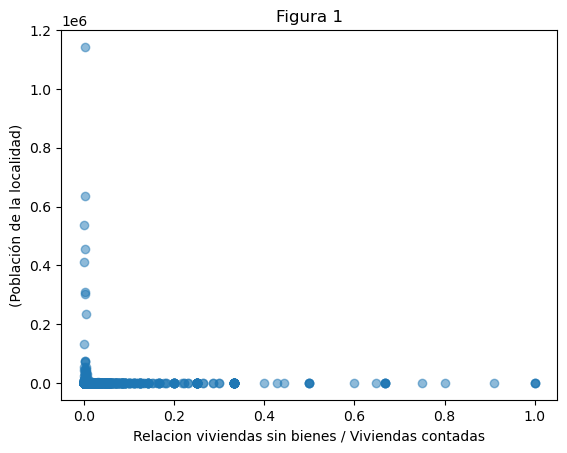

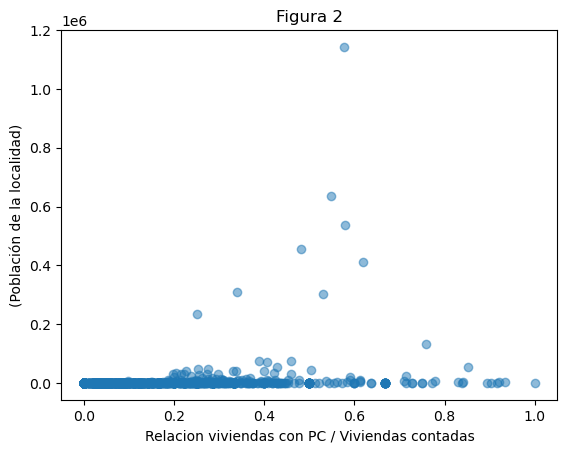

In [591]:
%matplotlib inline
plt.scatter(df.VPH_SNBIEN/df.VIVPARH_CV,(df.POBTOT),alpha = 0.5)
plt.xlabel("Relacion viviendas sin bienes / Viviendas contadas")
plt.ylabel("(Población de la localidad)")
plt.title("Figura 1")
plt.show()
plt.close()

plt.scatter(df.VPH_PC/df.VIVPARH_CV,(df.POBTOT),alpha = 0.5)
plt.xlabel("Relacion viviendas con PC / Viviendas contadas")
plt.ylabel("(Población de la localidad)")
plt.title("Figura 2")
plt.show()
plt.close()

Las figuras 1 y 2 se ven muy poco prometedoras, en un inicio no se le puede encontrar forma a las gráfica, pero quizá podamos encontrar un modelo con tendencias lineales si le aplicamos el logaritmo base 10 a la población.

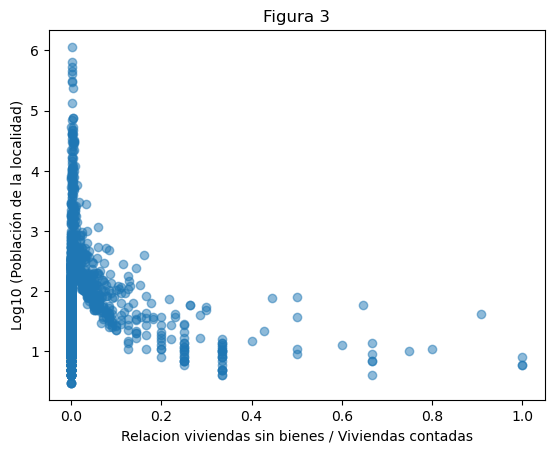

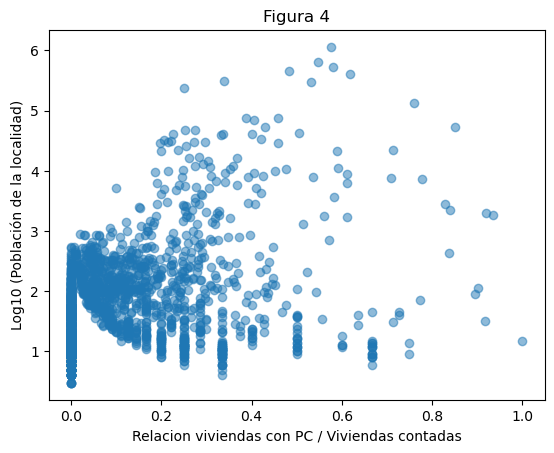

In [592]:

plt.scatter(df.VPH_SNBIEN/df.VIVPARH_CV,np.log10(df.POBTOT),alpha = 0.5)
plt.xlabel("Relacion viviendas sin bienes / Viviendas contadas")
plt.ylabel("Log10 (Población de la localidad)")
plt.title("Figura 3")
plt.show()
plt.close()

plt.scatter(df.VPH_PC/df.VIVPARH_CV,np.log10(df.POBTOT),alpha = 0.5)
plt.xlabel("Relacion viviendas con PC / Viviendas contadas")
plt.ylabel("Log10 (Población de la localidad)")
plt.title("Figura 4")
plt.show()
plt.close()

Mientras que la relación asociada a la cantidad de viviendas sin bienes pareciera tener un comportamiento muy similar al cuadrático, la relación asociada a las viviendas con PC no pareciera tener una forma muy definida. 
Aunque quizá para modelos de predicción algún método no paramétrico sería mejor, aquí se utilizará una regresión lineal múltiple y luego una regresión cuadrática múltiple. Esto porque facilitará mucho la interpretabilidad del modelo. 

Además, aunque sería muy tedioso revisar las características de las 55 variables, es razonable suponer que debe de haber más de una que tenga un comportamiento que se pueda modelar con métodos paramétricos, como la relación viviendas sin bienes/viviendas contadas. 


Se siguió adelante con el enfoque de usar la división de las viviendas con caracteristica particular sobre las viviendas totales para este proyecto. 

Las siguientes líneas de código dividen aritméticamente todas las columnas entre la columna de viviendas particulares habitadas a las que se les captan sus características (excepto las que representan otros valores como el promedio de ocupantes por vivienda y el promedio de ocupantes por cuarto)

In [593]:

#Esta linea de codigo fue hecha con ayuda de CHATGPT
excluirDiv = ['PROM_OCUP','PROM_OCUP_C','VIVPARH_CV','POBTOT','NOM_LOC']
df.loc[:,~df.columns.isin(excluirDiv) ] = df.loc[:,~df.columns.isin(excluirDiv)].div(df['VIVPARH_CV'],axis=0)
print(df.head())
df.drop('VIVPARH_CV',inplace = True,axis=1)

                  NOM_LOC  POBTOT    TOTHOG  HOGJEF_F  HOGJEF_M    POBHOG  \
4                 Abasolo    1992  1.000000  0.301471  0.698529  3.661765   
13  Los Diez (La Tripona)      15  1.000000  0.000000  1.000000  5.000000   
16     Colinas del Fraile      53  1.000000  0.214286  0.785714  3.785714   
17     Alberto Villarreal     870  1.013216  0.259912  0.753304  3.832599   
21             Agualeguas    2080  1.001325  0.242384  0.758940  2.747020   

    PHOGJEF_F  PHOGJEF_M  VIVPARH_CV  VIVPAR_DES  ...   VPH_CEL  VPH_INTER  \
4    1.029412   2.632353       544.0    0.306985  ...  0.920956   0.476103   
13   0.000000   5.000000         3.0    1.666667  ...  1.000000   0.000000   
16   0.857143   2.928571        14.0    0.928571  ...  1.000000   0.285714   
17   0.955947   2.876652       227.0    0.264317  ...  0.960352   0.370044   
21   0.545695   2.201325       755.0    0.605298  ...  0.876821   0.500662   

    VPH_STVP  VPH_SPMVPI   VPH_CVJ  VPH_SINRTV  VPH_SINLTC  VPH_SINC

# Valores atípicos.

En la siguiente sección se hace una prueba de rango de Tukey para los valores de población para ver que valores se podrían desvíar de lo esperado y revisar si es algo que debería de preocuparnos.

In [594]:
q1 = df.POBTOT.quantile(0.25)
q3 = df.POBTOT.quantile(0.75)
iqr = q3-q1

li = q1-(1.5*iqr)
ls = q3+(1.5*iqr)
print("Rango: (",li," , ",ls,")")

out = np.where((df.POBTOT <= li) | (df.POBTOT >= ls))[0]

#Se imprimiran el maximo y el minimo outlier

print("Valor atípico máximo : ",df.iloc[out,:].POBTOT.max())

print("Valor atípico mínimo : ",df.iloc[out,:].POBTOT.min())


print(df[df["POBTOT"]==df.iloc[out,:].POBTOT.max()])
df.drop('NOM_LOC',inplace = True,axis=1)



Rango: ( -167.125  ,  315.875 )
Valor atípico máximo :  1142952
Valor atípico mínimo :  317
        NOM_LOC   POBTOT    TOTHOG  HOGJEF_F  HOGJEF_M    POBHOG  PHOGJEF_F  \
4068  Monterrey  1142952  1.000761  0.323787  0.676974  3.465213   1.040229   

      PHOGJEF_M  VIVPAR_DES  VIVPAR_UT  ...   VPH_CEL  VPH_INTER  VPH_STVP  \
4068   2.424984    0.104286   0.016507  ...  0.908354   0.776567  0.495443   

      VPH_SPMVPI   VPH_CVJ  VPH_SINRTV  VPH_SINLTC  VPH_SINCINT  VPH_SINTIC  \
4068     0.37274  0.215132    0.017177    0.033936     0.191824    0.004865   

      DatosVacios  
4068            0  

[1 rows x 55 columns]


El valor atípico máximo proviene de la localidad de Monterrey. Una búsqueda rápida en internet puede confirmar los datos.

[Datos Monterrey](https://www.economia.gob.mx/datamexico/es/profile/geo/monterrey#:~:text=La%20poblaci%C3%B3n%20total%20de%20Monterrey,%25%20mujeres%20y%2049.4%25%20hombres) aquí se menciona la población de Monterrey, y cuadra con la del valor de la base de datos.
 
Aunque no estén fuera del rango interquantil podría preocupar el caso extremo de una localidad con una o dos personas. Pero realmente esto no es un error en la base de datos, existen localidades registradas así. [Información de una de ejemplo](https://mexico.pueblosamerica.com/i/la-lajilla-13/). Para el alcance de este proyecto, honestamente desconozco como se manejan y como llegan a existir estos "pueblos fantasmas", pero sé que existen y los mantendremos en la base de datos. 

Como se mencionó previamente, muchas variables de la base de datos pueden llegar a manejar información muy similar. Ya se borraron algunas cualitativamente previo a iniciar el reporte, sin embargo, podría haber más. Para detectarlas manejaré un heatmap de las variables y trataré de eliminar las que tengan mayor correlación. 

Hasta el momento habíamos guardado la variable NOM_LOC, esto era justo para la sección de valores atípicos, pues nos permitiría investigar las localidades que arrojen estos valores, pero ahora podemos borrarla para enfocarnos únicamente en datos numéricos.



# Correlación Parte 1

En un inicio se iban a buscar las correlaciones en las variables de la base de datos para eliminarlas, pero a continuación se muestra porque se prefirió no proseguir hasta después. 

[[1.         0.00473135 0.0340816  ... 0.18263886 0.02890459        nan]
 [0.00473135 1.         0.07156942 ... 0.05358705 0.01010109        nan]
 [0.0340816  0.07156942 1.         ... 0.02748603 0.02533818        nan]
 ...
 [0.18263886 0.05358705 0.02748603 ... 1.         0.22591808        nan]
 [0.02890459 0.01010109 0.02533818 ... 0.22591808 1.                nan]
 [       nan        nan        nan ...        nan        nan        nan]]
0  ,  53
nan


c:\Users\6QW59LA\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\6QW59LA\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


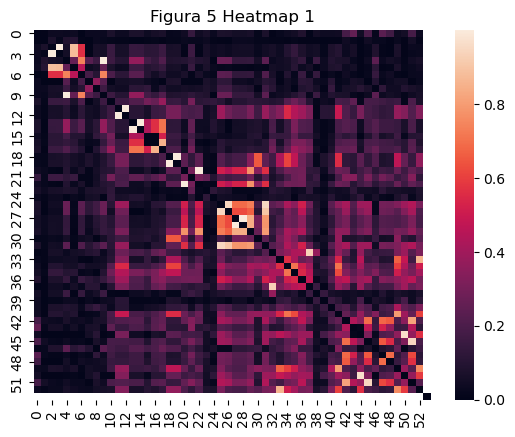

In [595]:
cor = abs(np.corrcoef(df,rowvar = False))
print(cor)
np.fill_diagonal(cor,0)
#sirve para encontrar valor máximo de correlación
i,j = np.unravel_index(cor.argmax(),cor.shape)
print(i," , ",j)

print(cor[i,j])

from seaborn import heatmap
heatmap(cor)
plt.title("Figura 5 Heatmap 1")
plt.show()
plt.close()

Si bien, existen variables con una alta correlación, hay demasiadas variables como para hacer una selección manual. Por lo que primero se va a hacer un proceso de selección de características y luego, si llegan a quedar procederemos a eliminar las correlacionadas. 


# Primer Modelo

Primero se va a generar un modelo con todas las variables, solo para tener una referencia cuando los vayamos a comparar más adelante. Se separarán los datos de prueba y datos de entrenamiento, además de datos de prueba internas al entrenamiento para evitar fugas de datos.



Para este modelo de regresión se utilizará la función OLS de la libreria statsmodels.api. OLS significa ordinary least squares y en esta metodología se busca reducir una métrica, usualmente el Residual Sum of Squares en los coeficientes de un modelo lineal de multiples variables. 

Esta librería es muy práctica porque nos puede regresar un resumen con todos los coeficientes y su valor p- ante una prueba de hipótesis con el estadístico t. Esto nos indicaría si los coeficientes encontradaos de cada variable del modelo de regresión es estadísticamente significativo.

También se incluye una prueba de hipótesis para un estadístico F que prueba si al menos una variable es estadísticamente significativa (para evitar falsos descubrimientos).

Además, con los "datos de preba internos" se calculará la R^2 ajustada y RSE; para acelerar el proceso la R^2 se encontrará con la función  r2_score de la librería sklearn.metrics. Aunque el resumen de statsmodels.api si nos da una R^2 y R^2 ajustada, se calcula con los datos de entrenamiento, lo que hace que el modelo pueda tener un sobreajuste y aparentar tener valores más altos de los que debería. 



Valores calculados con datos de prueba internos:
RSE modelo con  53  variables  0.9528310925589987
R2 Ajustada modelo con  53  variables -0.7434662723845598 R2  -0.4528885603204664
                            OLS Regression Results                            
Dep. Variable:                 POBTOT   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     71.11
Date:                Thu, 20 Feb 2025   Prob (F-statistic):          2.67e-322
Time:                        02:51:05   Log-Likelihood:                -652.53
No. Observations:                1273   AIC:                             1407.
Df Residuals:                    1222   BIC:                             1670.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                  coef    std

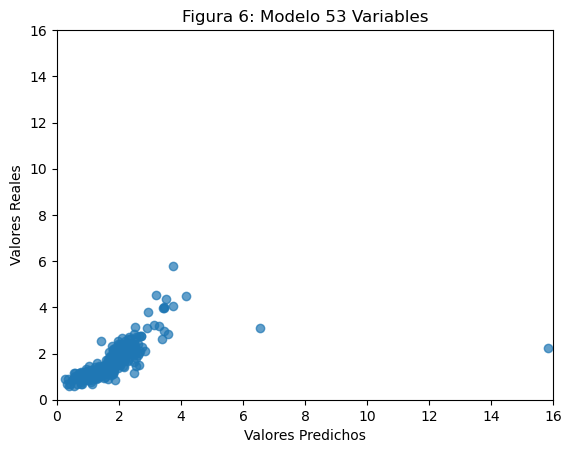

In [596]:
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
import statsmodels.api as sm
# Genera los datos de entrenamiento y validación
#le damos una semilla al random state para poder hacer el análisis sin que varíen los datos cada vez que corra de nuevo el programa

train, test = train_test_split(df, train_size= 0.8, random_state=855)

train, intest = train_test_split(train,train_size=0.8,random_state= 546)
Y_train = np.log10(train.POBTOT)
X_train = train.drop('POBTOT',axis=1)

#datos de prueba internos
X_intest = intest.drop('POBTOT',axis=1)
Y_intest = np.log10(intest.POBTOT)


m1 = X_train.shape[1]
n = X_intest.shape[0]
model1 = sm.OLS(Y_train,sm.add_constant(X_train))
results = model1.fit()
#prueba con datos de prueba internos

yhat1 = results.predict(sm.add_constant(X_intest))

ybarIn = np.mean((Y_intest))
RSS1 = sum((yhat1-Y_intest)**2)
TSS = sum((ybarIn-Y_intest)**2)
RSE1 = np.sqrt(RSS1/(n-m1-1))
R2Adj1 = 1 - ( (RSS1/(n-m1-1)) / (TSS/(n-1)))
print("Valores calculados con datos de prueba internos:")
print("RSE modelo con ",m1," variables ",RSE1)
print("R2 Ajustada modelo con ",m1, " variables",R2Adj1, "R2 ",r2_score(Y_intest,  yhat1))


print(results.summary())

plt.scatter(yhat1,Y_intest,alpha= 0.7)
plt.xlim(0,16)
plt.ylim(0,16)
plt.xlabel("Valores Predichos")
plt.ylabel("Valores Reales")
plt.title("Figura 6: Modelo 53 Variables")
plt.show()
plt.close()

El primer modelo tiene un valor p asociado al estadístico F menor a 0.05, esto quiere decir que hay una muy alta probabilidad de que al menos una variable sea estadísticamente significativa.
Es decir, es muy probable que por lo menos una de las características que tienen las viviendas tengan una relación con la población. 

 Sin embargo, se puede observar que hay muchas variables que no son significativas y que muy probablemente afectan negativamente al desempeño del modelo.

Aunque el resumen de datos nos da una R^2 ajustada de 0.744, nuestro calculo nos dio una de  -0.4528. Muy poca de la varianza del modelo se explica por el modelo. Esto se puede ver en los datos dispersos en la figura 6, en los que el modelo predijo valores de población mucho mayores que los reales, lo que probablemente indican un sobre ajuste en los datos de entrenamiento.

El modelo tiene un Residual Standard Error de casi uno cuando los valores de validación van de 0 a 6. Es un error bastante considerable en los datos.

# Selección de Características

En la sección pasada no se analizarón  a detalle las variables, porque en esta sección se buscarán reducir de  las 55 variables actuales a menos de diez. 

La metodología a utilizar es la de selección hacia adelante. Se eligió por ser sencilla pero a la vez  necesitar muchos menos recursos que la selección del mejor  subconjunto. 

Se restringió a la función para que regresé a lo mucho 10 variables, utilice como métrica para seleccionar las variables la R^2 y que se comparen los distintos modelos con una validación cruzada de 10 folds. 


In [597]:


model_1= LinearRegression()

subX = SequentialFeatureSelector(model_1, k_features=(2,10),forward = True, scoring = 'r2', cv = 10).fit(X_train,Y_train)
print("Variables seleccionadas", subX.k_feature_names_)
NewIndx = list(subX.k_feature_idx_)
XNew = X_train.iloc[:,NewIndx[:]]
#mismo procedimiento para prueba interna
X_NewIntest = X_intest.iloc[:,NewIndx[:]]


Variables seleccionadas ('VIVPAR_UT', 'PROM_OCUP', 'PRO_OCUP_C', 'VPH_2CUART', 'VPH_3YMASC', 'VPH_AEASP', 'VPH_DSADMA', 'VPH_NDACMM', 'VPH_TELEF', 'VPH_INTER')


Aunque lo que significa cada una de estas variables se encuentra en el diccionario de datos, no está de maz incluir aquí que significan, tomando en cuenta que ahora son mucho menos variables.

VIVPAR_UT = (Proporción) Viviendas particulares de uso temporal.

PROM_OCUP = Resultado de dividir el número de personas que residen en viviendas particulares habitadas, entre el número de esas viviendas.

PROM_OCUP_C = Resultado de dividir el número de personas que residen en viviendas particulares habitadas entre el número de cuartos de esas viviendas. 

VIVPH_2CUART = Viviendas particulares habitadas que tienen dos cuartos.

VIVPH_3YMASC = Viviendas particulares habitadas que tienen entre 3 y 25 cuartos. 


VPH_AEASP = Viviendas particulares habitadas que disponen de agua entubada y se abastecen del servicio público de agua


VPH_DSADMA = Viviendas particulares habitadas que tienen drenaje conectado a la red pública; una fosa séptica o tanque séptico (biodigestor); una tubería que va a dar a una barranca o grieta, río, lago o mar; taza de baño (excusado o sanitario); letrina (pozo u hoyo) con admisión de agua.

VPH_NDACMM = Viviendas particulares habitadas que no disponen de automóvil o camioneta, ni de motocicleta o motoneta

VPH_TELEF = Viviendas particulares habitadas que tienen línea telefónica fija.

VPH_INTER = Viviendas particulares habitadas que tienen Internet.





# Segundo Modelo


Se hará otro modelo de regresión lineal con estas características. Se seguirá la misma metodología que para el primero. 


Valores calculados con datos de prueba internos:
RSE modelo con  10  variables 0.4084211111124368
R2 Ajustada modelo con  10  variables  0.6796696603041621  R2   0.6897429414266728
                            OLS Regression Results                            
Dep. Variable:                 POBTOT   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     324.4
Date:                Thu, 20 Feb 2025   Prob (F-statistic):               0.00
Time:                        02:51:22   Log-Likelihood:                -710.24
No. Observations:                1273   AIC:                             1442.
Df Residuals:                    1262   BIC:                             1499.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std 

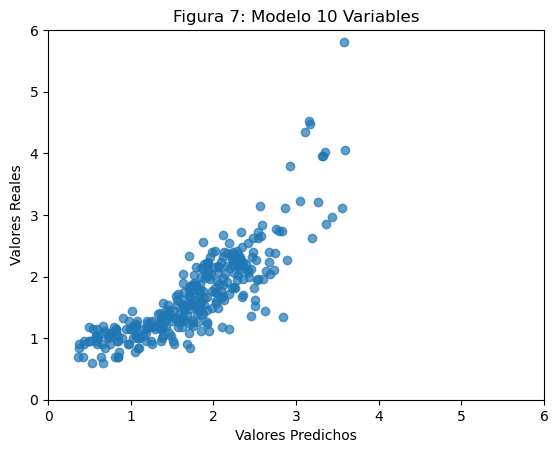

In [598]:


model2 = sm.OLS(Y_train,sm.add_constant(XNew)).fit()
m2 = XNew.shape[1]
yhat2 = model2.predict(sm.add_constant(X_NewIntest))
RSS2 = sum((yhat2-Y_intest)**2)
RSE2 = np.sqrt(RSS2/(n-m2-1))
R2Adj2 = 1 - ( (RSS2/(n-m2-1)) / (TSS/(n-1)))

print("Valores calculados con datos de prueba internos:")
print("RSE modelo con ",m2, " variables",RSE2)
print("R2 Ajustada modelo con ",m2, " variables ",R2Adj2, " R2  ",r2_score(Y_intest,yhat2))

print(model2.summary())
plt.scatter(yhat2,Y_intest,alpha=0.7)
plt.xlabel("Valores Predichos")
plt.ylabel("Valores Reales")
plt.title("Figura 7: Modelo 10 Variables")
plt.ylim(0,6)
plt.xlim(0,6)
plt.show()
plt.close()


Este modelo también tiene un valor-p asociado a F menor a 0.05. Además de que todas las variables son estadísticamente significativas, por lo que por lo menos sería igual de bueno que el modelo original, pero mucho más interpretable.

Ahora veremos que esta modelo súpera por mucho al de 55 variables en cuanto a la R^2 ajustada que ahora es de 0.679, también el RSE mejoró bastante, es de 0.408, prácticamente la mitad que el primer modelo.


# Correlación de variables pt. 2 


Ahora que hay muchísimas menos variables, es más sencillo verificar si hay algunas con alta correlación. 
El código de esta sección encuentra dos variables muy correlacionadas, VIVPH_2CUART y VIVPH_3YMASC de las cuales se decidió eliminar una (VIVPH_2CUART) y comprobar si eso mejoraba el desempeño del modelo. El desempeño del modelo, aunque por muy poco si mejoró y se aumentó la R^2 ajustada a 0.690 y el RSE disminuyó a 0.401.

3  ,  4
0.8528741351012743
Index(['VIVPAR_UT', 'PROM_OCUP', 'PRO_OCUP_C', 'VPH_2CUART', 'VPH_3YMASC',
       'VPH_AEASP', 'VPH_DSADMA', 'VPH_NDACMM', 'VPH_TELEF', 'VPH_INTER'],
      dtype='object')


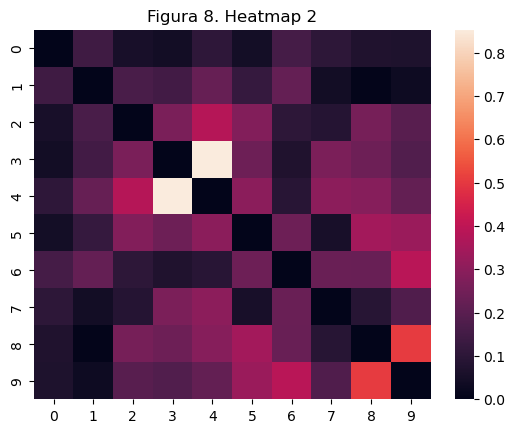

In [599]:
cor = abs(np.corrcoef(XNew,rowvar = False))
np.fill_diagonal(cor,0)
#sirve para encontrar valor máximo de correlación
i,j = np.unravel_index(cor.argmax(),cor.shape)
print(i," , ",j)

print(cor[i,j])
print(XNew.columns)
from seaborn import heatmap
heatmap(cor)
plt.title("Figura 8. Heatmap 2")
plt.show()
plt.close()



In [600]:
XNew.drop('VPH_2CUART',inplace=True, axis =1)
X_NewIntest.drop('VPH_2CUART',inplace = True, axis = 1)
cor = abs(np.corrcoef(XNew,rowvar = False))
np.fill_diagonal(cor,0)
#sirve para encontrar valor máximo de correlación
i,j = np.unravel_index(cor.argmax(),cor.shape)
print(i," , ",j)

print(cor[i,j])



7  ,  8
0.5058612070683499


C:\Users\6QW59LA\AppData\Local\Temp\ipykernel_18708\213889679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XNew.drop('VPH_2CUART',inplace=True, axis =1)
C:\Users\6QW59LA\AppData\Local\Temp\ipykernel_18708\213889679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_NewIntest.drop('VPH_2CUART',inplace = True, axis = 1)


Las dos variables más correlacionadas corresponde a la proporción de viviendas que tienen dos cuartos y la proporción de viviendas que tienen de 3 a 25 cuartos. Probablemente por terminos de interpretabilidad sería mejor quedarse con la variable VPH_3YMASC, por lo que se eliminará VPH_2CUART.




Valores calculados con datos de prueba internos:
R2 Ajustada modelo con  9  variables  0.6901967396338655 R2  0.6989647564366808
RSE modelo con  9  variables 0.40165403786969067
                            OLS Regression Results                            
Dep. Variable:                 POBTOT   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     351.0
Date:                Thu, 20 Feb 2025   Prob (F-statistic):               0.00
Time:                        02:51:22   Log-Likelihood:                -722.78
No. Observations:                1273   AIC:                             1466.
Df Residuals:                    1263   BIC:                             1517.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err

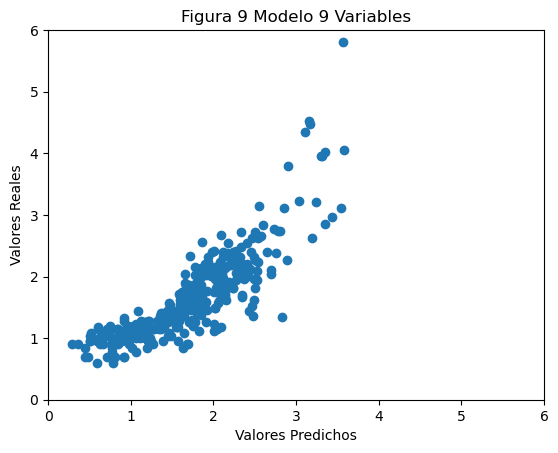

In [601]:
m3 = XNew.shape[1]
model3 = sm.OLS(Y_train,sm.add_constant(XNew)).fit()
yhat3 = model3.predict(sm.add_constant(X_NewIntest))
RSS3 = sum((yhat3-Y_intest)**2)
RSE3 = np.sqrt(RSS3/(n-m3-1))
R2Adj3 = 1 - ( (RSS3/(n-m3-1)) / (TSS/(n-1)))

print("Valores calculados con datos de prueba internos:")
print("R2 Ajustada modelo con ",m3, " variables ", R2Adj3, "R2 ", r2_score(Y_intest,yhat3))
print("RSE modelo con ",m3, " variables",RSE3)

print(model3.summary())
plt.scatter(yhat3,Y_intest)
plt.xlabel("Valores Predichos")
plt.ylabel("Valores Reales")
plt.title("Figura 9 Modelo 9 Variables")
plt.ylim(0,6)
plt.xlim(0,6)
plt.show()
plt.close()

# Modelo cuadrático
Ahora, si se presta atención al último modelo realizado, hay 9 variables estadísticamente significativas relacionadas a las condiciones de vivienda que afectan al logaritmo base 10 de la población total de una localidad.

Esta relación se asume lineal, pero podría no serlo. De hecho, vimos formas curvas en la introducción.

Para este último modelo le daremos un término cuadrático a las variables con coeficientes negativos. Esto porque como la población no puede pasar a números negativos, se tiene la idea de que la pendiente de la curva se debe de bajar llegando a cierto punto.  

Para añadir los coeficientes cuadráticos simplemente se añadió una columna por variable cuadrática de la variable multiplicándose por sí misma.



In [602]:

XNew.insert(2,"PRO_OCUP_C^2",XNew.PRO_OCUP_C*XNew.PRO_OCUP_C)
XNew.insert(4,"VPH_3YMASC^2",XNew.VPH_3YMASC*XNew.VPH_3YMASC)
XNew.insert(1,"VIVPAR_UT^2",XNew.VIVPAR_UT*XNew.VIVPAR_UT)

#mismo procedimiento para prueba interna

X_NewIntest.insert(2,"PRO_OCUP_C^2",X_NewIntest.PRO_OCUP_C*X_NewIntest.PRO_OCUP_C)
X_NewIntest.insert(4,"VPH_3YMASC^2",X_NewIntest.VPH_3YMASC*X_NewIntest.VPH_3YMASC)
X_NewIntest.insert(1,"VIVPAR_UT^2",X_NewIntest.VIVPAR_UT*X_NewIntest.VIVPAR_UT)


print(XNew.shape)
print(XNew.columns)

(1273, 12)
Index(['VIVPAR_UT', 'VIVPAR_UT^2', 'PROM_OCUP', 'PRO_OCUP_C^2', 'PRO_OCUP_C',
       'VPH_3YMASC^2', 'VPH_3YMASC', 'VPH_AEASP', 'VPH_DSADMA', 'VPH_NDACMM',
       'VPH_TELEF', 'VPH_INTER'],
      dtype='object')


Valores calculados con datos de prueba internos:
R2 Ajustada modelo cuadratico  0.7569163458672635  R2  0.7660893139477443
RSE modelo cuadratico 0.35578449970531095
                            OLS Regression Results                            
Dep. Variable:                 POBTOT   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     366.5
Date:                Thu, 20 Feb 2025   Prob (F-statistic):               0.00
Time:                        02:51:23   Log-Likelihood:                -564.30
No. Observations:                1273   AIC:                             1155.
Df Residuals:                    1260   BIC:                             1222.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t

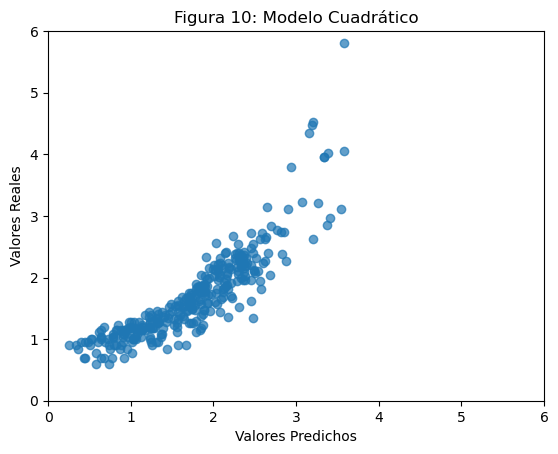

In [603]:
m4 = XNew.shape[1]
model4 = sm.OLS(Y_train, sm.add_constant(XNew))
results4 = model4.fit()
yhat4 = results4.predict(sm.add_constant(X_NewIntest))
RSS4 = sum((yhat4-Y_intest)**2)
RSE4 = np.sqrt(RSS4/(n-m4-1))
R2Adj4 = 1 - ( ( RSS4/(n-m4-1) ) / (TSS/(n-1)) )

print("Valores calculados con datos de prueba internos:")
print("R2 Ajustada modelo cuadratico ", R2Adj4, " R2 ",r2_score(Y_intest,yhat4))
print("RSE modelo cuadratico",RSE4)

print(results4.summary())
plt.scatter(yhat4,Y_intest,alpha=0.7)
plt.xlabel("Valores Predichos")
plt.ylabel("Valores Reales")
plt.title("Figura 10: Modelo Cuadrático")
plt.ylim(0,6)
plt.xlim(0,6)
plt.show()
plt.close()



Este modelo tiene el valor de R^2 ajustada más alto, con 0.7569y un RSE de 0.355, el más bajo de todos los modelos entrenados en este proyecto. 

En cuanto a la importancia estadística, dos de las 3 variables cuadráticas tenían un valor estadísticamente significativo, por lo que fue una buena idea añadirlas al modelo. Sobre la interpretación de esto se hablará más adelante, en el análisis de inferencia. 

El modelo cuadrático es el que se considera más apto de los vistos en el proyecto, por lo que es el que se va a pasar por los datos de prueba. 

C:\Users\6QW59LA\AppData\Local\Temp\ipykernel_18708\1659100776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XtestNew.drop('VPH_2CUART',inplace=True, axis =1)


RSE modelo final  0.4264754199960451
R2 Ajustada modelo final 0.8002326400102144 R2  0.8077710309532252


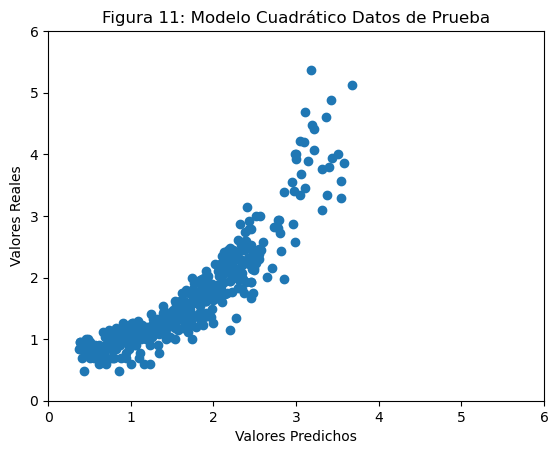

In [604]:
Y_test = np.log10(test.POBTOT)
X_test = test.drop('POBTOT',axis=1)
XtestNew = X_test.iloc[:,NewIndx[:]]
XtestNew.drop('VPH_2CUART',inplace=True, axis =1)
XtestNew.insert(2,"PRO_OCUP_C^2",XtestNew.PRO_OCUP_C*XtestNew.PRO_OCUP_C)
XtestNew.insert(4,"VPH_3YMASC^2",XtestNew.VPH_3YMASC*XtestNew.VPH_3YMASC)
XtestNew.insert(1,"VIVPAR_UT^2",XtestNew.VIVPAR_UT*XtestNew.VIVPAR_UT)


yhatTest = results4.predict(sm.add_constant(XtestNew))
m = XtestNew.shape[1]
RSSTest = sum((yhatTest-Y_test)**2)
ybar = np.mean(Y_test)
TSSTest = sum((ybar-Y_test)**2)
RSETest =  np.sqrt(RSSTest/(n-m-1))
R2AdjF = 1 - ( (RSSTest/(n-m-1)) / (TSSTest/(n-1)))

print("RSE modelo final ",RSETest)
print("R2 Ajustada modelo final",R2AdjF, "R2 ",r2_score(Y_test, yhatTest))


plt.scatter(yhatTest,Y_test)
plt.xlabel("Valores Predichos")
plt.ylabel("Valores Reales")
plt.title("Figura 11: Modelo Cuadrático Datos de Prueba")
plt.ylim(0,6)
plt.xlim(0,6)

plt.show()
plt.close()


Para los datos de validación o prueba, el modelo cuadrático tuvo una mejor R^2, pero un RSE mayor. Aún así, son valores muy similares a los de entrenamiento, lo que indica que este modelo tiene un buen desempeño con datos nuevos. 

# Analisis de inferencia. 

Finalmente, se hará un analisis de inferencia entrenando el mismo modelo cuadrático con toda la base de datos.  

In [605]:
Y = np.log10(df.POBTOT)
X = df.drop('POBTOT',axis=1)
XNew = X.iloc[:,NewIndx[:]]
XNew.drop('VPH_2CUART',inplace=True, axis =1)
XNew.insert(2,"PRO_OCUP_C^2",XNew.PRO_OCUP_C*XNew.PRO_OCUP_C)
XNew.insert(4,"VPH_3YMASC^2",XNew.VPH_3YMASC*XNew.VPH_3YMASC)
XNew.insert(1,"VIVPAR_UT^2",XNew.VIVPAR_UT*XNew.VIVPAR_UT)

model = sm.OLS(Y,sm.add_constant(XNew))
results  = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 POBTOT   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     598.3
Date:                Thu, 20 Feb 2025   Prob (F-statistic):               0.00
Time:                        02:51:23   Log-Likelihood:                -850.61
No. Observations:                1990   AIC:                             1727.
Df Residuals:                    1977   BIC:                             1800.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.2040      0.068     17.818   

C:\Users\6QW59LA\AppData\Local\Temp\ipykernel_18708\1713913836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XNew.drop('VPH_2CUART',inplace=True, axis =1)


De los coeficientes de la regresión podemos hacer algunas inferencias del comportamiento de los datos. 
Por ejemplo, la variable PROM_OCUP_C y PROM_OCUP_C^2 indican que en un inicio se puede esperar que por cada ocupante promedio por habitación que haya en una vivienda se espera una caída lineal del logaritmo base 10 de la población de entre -6.703 a -6.116. Sin embargo, conforme aumentan la cantidad de ocupantes promedio por cuarto, el componente cuadrático empieza a tener más peso entonces se espera un aumento en la población. Esto podría significar que los pueblos más pequeños tienen a varias personas ocupando un mismo cuarto, los pueblos medianes tienden a tener menos ocupantes por cuarto y las localidades grandes suelen tener a varias personas por cuarto. 

Las otras variables con exponente cuadrático o no son estadísticamente significativas o tienen un coeficiente muy pequeño. Por lo que no considero que valga la pena tomar mucho tiempo mencionarlas.

Ahora, las condiciones de vivienda y como afectan la población. 
Las últimas 5 variables del modelo miden la proporción de viviendas que cuentan o carecen con determinado servicio y como esto se relaciona con el logaritmo base 10 de la población. 

Por ejemplo, si el 100% de viviendas tuvieran agua entubada o se abastece del servicio público de agua se esperaría un aumento del logaritmo base 10 de la población de entre 0.272 y 0.369. Esta variable es muy similar a la que mide que tengan algún tipo de drenaje, fosa séptica, pozo, etc. que tiene un coeficiente lineal de entre 0.053 y 0.163 Esto podría indicar que el acceso a drenaje es muy importante para el crecimiento de una localidad.

Parece muy extraño que la proporción de viviendas sin algún vehículo motorizado parece demostrar un aumento en la población. Esto puede deberse a que en poblaciones muy grandes haya una tan alta cantidad de personas, que por muchos vehículos que tengan siempre va a haber una baja proporción de viviendas con vehículo. 

Por último, se nota que las telecomunicaciones también son muy importantes para el aumento de la población. Si el 100% de viviendas tuvieran acceso a un teléfono se esperaría un aumento del logaritmo base 10 de la población de entre 0.817 y 1.080. Para el caso en el que el 100% de las viviendas tuvieran acceso a internet se esperaría un aumento del logaritmo base 10 de la población desde 0.438 y 0.619.

Esta información es de interés para cualquier entidad que está interesada en aumentar la población o evitar perderla y crear más pueblos fantasma, pues indica cuales serían los servicios a los que más atención se le debe de dar para tener una mayor población.



